# **Looping Graph**

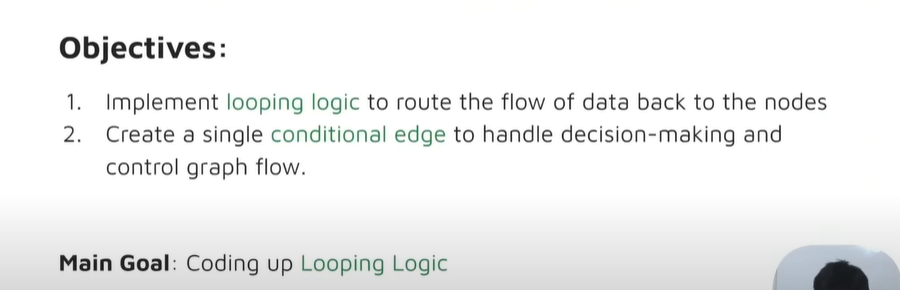

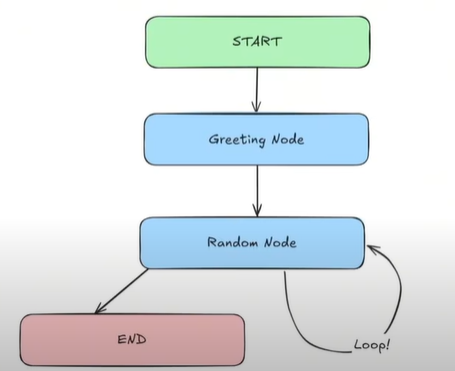

In [ ]:
from langgraph.graph import StateGraph, END
import random
from typing import Dict, List, TypedDict

In [2]:
class AgentState(TypedDict):
    name : str
    number : List[int]
    counter : int    

In [3]:
def greeting_node(state: AgentState) -> str:
    """Greeting node which says hi to the person."""
    state["name"] = f"Hy there, {state['name']}!"
    state["counter"] = 0
    return state

def random_number_node(state: AgentState) -> str:
    """Generates a random number 0 to 10."""
    state["number"].append(random.randint(0, 10))
    state["counter"] += 1
    return state

def should_continue_node(state: AgentState) -> str:
    """Function to decide what to do next."""
    if state["counter"] < 5:
        print("ENTERING LOOP", state["counter"])
        return "loop"
    else:
        return "exit"

In [4]:
# greeting node -> random -> random -> random ->  random -> random -> should_continue -> exit

In [8]:
graph = StateGraph(AgentState)

# add node
graph.add_node("greeting", greeting_node)
graph.add_node("random", random_number_node)

# add edge
graph.add_edge("greeting", "random")

# add conditional edge
graph.add_conditional_edges(
    "random", 
    should_continue_node, 
    {   
     "loop" : "random",
     "exit" : END
    }
)

graph.set_entry_point("greeting")
# thier no need to set the exit point, it is END by default in 14 line

app = graph.compile()


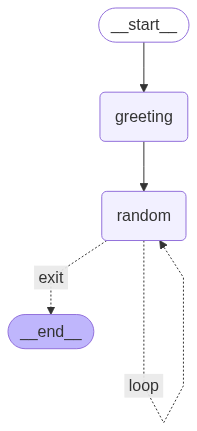

In [10]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)))

In [11]:
app.invoke({"name": "John", "number": [], "counter": 0})

ENTERING LOOP 1
ENTERING LOOP 2
ENTERING LOOP 3
ENTERING LOOP 4


{'name': 'Hy there, John!', 'number': [5, 4, 1, 3, 4], 'counter': 5}

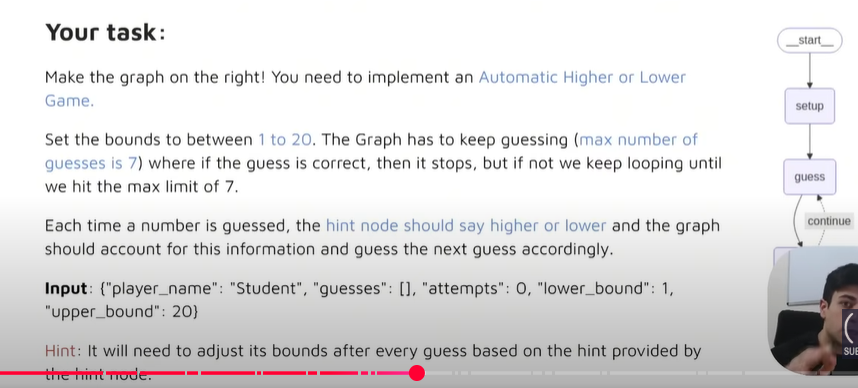

In [1]:
from langgraph.graph import StateGraph, END
import random
from typing import Dict, List, TypedDict

In [2]:
class GameState(TypedDict):
    player_name: str
    target_number: int
    guesses: List[int]
    attempts: int
    hint: str
    lower_bound: int 
    upper_bound: int 

In [5]:
def setup_node(state: GameState) -> GameState:
    """Initialize the game with a random target number"""
    state["player_name"] = f"Welcome, {state['player_name']}!"
    state["target_number"] = random.randint(1, 20)
    state["guesses"] = []
    state["attempts"] = 0
    state["hint"] = "Game started! Try to guess the number."
    state["lower_bound"] = 1 
    state["upper_bound"] = 20 
    print(f"{state['player_name']} The game has begun. I'm thinking of a number between 1 and 20.")
    return state

def guess_node(state: GameState) -> GameState:
    """Generate a smarter guess based on previous hints"""
    
    possible_guesses = [i for i in range(state["lower_bound"], state["upper_bound"] + 1) if i not in state["guesses"]]
    if possible_guesses:
        guess = random.choice(possible_guesses)
    else:
        
        guess = random.randint(state["lower_bound"], state["upper_bound"])
    
    state["guesses"].append(guess)
    state["attempts"] += 1
    print(f"Attempt {state['attempts']}: Guessing {guess} (Current range: {state['lower_bound']}-{state['upper_bound']})")
    return state

def hint_node(state: GameState) -> GameState:
    """Here we provide a hint based on the last guess and update the bounds"""
    latest_guess = state["guesses"][-1]
    target = state["target_number"]
    
    if latest_guess < target:
        state["hint"] = f"The number {latest_guess} is too low. Try higher!"
        
        state["lower_bound"] = max(state["lower_bound"], latest_guess + 1)
        print(f"Hint: {state['hint']}")
        
    elif latest_guess > target:
        state["hint"] = f"The number {latest_guess} is too high. Try lower!"
      
        state["upper_bound"] = min(state["upper_bound"], latest_guess - 1)
        print(f"Hint: {state['hint']}")
    else:
        state["hint"] = f"Correct! You found the number {target} in {state['attempts']} attempts."
        print(f"Success! {state['hint']}")
    
    return state

def should_continue(state: GameState) -> str:
    """Determine if we should continue guessing or end the game"""
    
    # There are 2 end conditions - either 7 is reached or the correct number is guessed
    
    latest_guess = state["guesses"][-1]
    if latest_guess == state["target_number"]:
        print(f"GAME OVER: Number found!")
        return "end"
    elif state["attempts"] >= 7:
        print(f"GAME OVER: Maximum attempts reached! The number was {state['target_number']}")
        return "end"
    else:
        print(f"CONTINUING: {state['attempts']}/7 attempts used")
        return "continue"

In [6]:
graph = StateGraph(GameState)
graph.add_node("setup", setup_node)
graph.add_node("guess", guess_node)
graph.add_node("hint_node", hint_node)  


graph.add_edge("setup", "guess")
graph.add_edge("guess", "hint_node")  


graph.add_conditional_edges(
    "hint_node", 
    should_continue,
    {
        "continue": "guess",
        "end": END
    }
)

graph.set_entry_point("setup")
app = graph.compile()


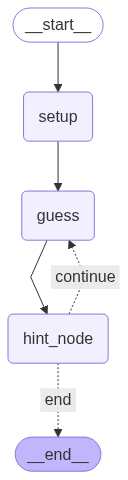

In [7]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
result = app.invoke({"player_name": "Student", "guesses": [], "attempts": 0, "lower_bound": 1, "upper_bound": 20})

Welcome, Student! The game has begun. I'm thinking of a number between 1 and 20.
Attempt 1: Guessing 2 (Current range: 1-20)
Hint: The number 2 is too low. Try higher!
CONTINUING: 1/7 attempts used
Attempt 2: Guessing 13 (Current range: 3-20)
Hint: The number 13 is too high. Try lower!
CONTINUING: 2/7 attempts used
Attempt 3: Guessing 6 (Current range: 3-12)
Hint: The number 6 is too high. Try lower!
CONTINUING: 3/7 attempts used
Attempt 4: Guessing 3 (Current range: 3-5)
Success! Correct! You found the number 3 in 4 attempts.
GAME OVER: Number found!
